In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from R125_bmimBF4_PR import configuration
data = pd.read_csv('R125_bmimBF4.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [18]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

m.fs.properties.PR_kappa_A['bmimBF4', 'R125'].fix(0.35)
m.fs.properties.PR_kappa_A['R125', 'bmimBF4'].fix(0.033)


# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'bmimBF4'].unfix()

R125 = np.linspace(0.01,0.38,12)

R125_x = np.zeros((len(R125)))
P = np.zeros((len(R125)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimBF4"] == m.fs.liq)
# m.fs.press = Constraint(expr=m.fs.F101.vap_outlet.pressure[0] <= 1.1e6)
for i in range(len(R125)):
    m.fs.liq = 1-R125[i]
    a = i * 50000
    m.fs.F101.inlet.temperature.fix(298)
    m.fs.F101.inlet.pressure.fix(a)
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(R125[i]+0.05)
    m.fs.F101.inlet.mole_frac_comp[0,'bmimBF4'].fix(1-(R125[i]+0.05))
    m.fs.F101.vap_outlet.temperature.fix(298)
    print("x =", R125[i])
    
    try:
        
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R125_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')

    except ValueError:

        R125_x[i] = 'NaN'
        P[i] = 'NaN'

x = 0.01
x = 0.04363636363636364
x = 0.07727272727272727
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Infeasible.
x = 0.11090909090909092
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Infeasible.
x = 0.14454545454545456
x = 0.1781818181818182
x = 0.21181818181818185
x = 0.24545454545454548
x = 0.2790909090909091
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Infeasible.
x = 0.31272727272727274
x = 0.3463636363636364
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
        inf

In [19]:
print(P)
print(data["pressure"])
print(R125_x)
print(data["x_R125"])

[              nan   254362.18991074        0.                0.
   805890.66867415   972856.4233627   1128122.14443119  1269308.18557109
        0.         11745211.89043816        0.          1639087.91772927]
0      50000
1     100000
2     200000
3     400000
4     600000
5     799500
6    1000000
Name: pressure, dtype: int64
[       nan 0.04363636 0.         0.         0.14454545 0.17818182
 0.21181818 0.24545455 0.         0.31272727 0.         0.38      ]
0    0.008
1    0.019
2    0.043
3    0.101
4    0.172
5    0.263
6    0.378
Name: x_R125, dtype: float64


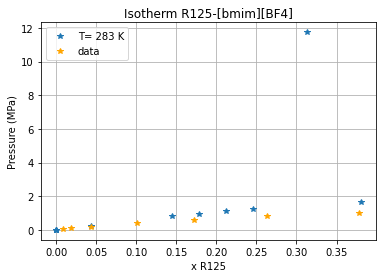

In [20]:
# for i in range(len(P)):
#     P[i] = P[i]*1e6
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

    
# plt.plot(R125_x,P1,"b","*",label="T= 283 K") 
plt.plot(R125_x,P1,"*",label="T= 283 K")  
plt.plot(data["x_R125"],data["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R125-[bmim][BF4]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R125')
plt.grid(True)
# plt.ylim(0,1.110000)
# plt.xlim(0,0.5)
plt.legend()
plt.show()

In [6]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value      : Fixed : Bounds
          Heat Duty :    -1676.8 : False : (None, None)
    Pressure Change : 6.5541e+05 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                   1.0000     0.076923       0.92308  
    mole_frac_comp bmimBF4    0.60000   1.0000e-08       0.65000  
    mole_frac_comp R125       0.40000       1.0000       0.35000  
    temperature                298.00       298.00        298.00  
    pressure               9.3332e+05   1.5887e+06    1.5887e+06  


In [7]:
# print(P1)

In [8]:
df = pd.DataFrame(P)
# df.to_csv('P_cons_125.csv')
# df.to_csv('P_lin_125.csv')
# df.to_csv('P_ter_125.csv')

In [9]:
# m.display()